In [1]:
# yolov5x6 trained

In [2]:
mount_drive=True
reduced=False

In [3]:
%%bash
find . \! -name 'rotated2.zip' -delete

In [4]:
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab
from collections import Counter


import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

import shutil
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [5]:
%%capture
!wget https://raw.githubusercontent.com/scikit-multilearn/scikit-multilearn/master/skmultilearn/model_selection/iterative_stratification.py
from iterative_stratification import *

In [6]:
if not mount_drive:
  !gdown 1X3O2v3GIPveq3ylWF6o1qHI5uzbN1vWA # download organized TACO images (TACO itself, 1500 images, without unofficial images)

if mount_drive:
  from google.colab import drive
  drive.mount('/gdrive')
  if not os.path.isfile('/content/rotated2.zip'):
    %cp /gdrive/MyDrive/rotated2_og.zip /content/rotated2.zip

Mounted at /gdrive


In [7]:
!unzip -qq rotated2.zip
%mv /content/content/* /content

In [8]:
!pwd

/content


In [51]:
nr_imgs=None
for root, dirnames, filenames in os.walk('./yoloTACO/labels/'):
  nr_imgs = len(filenames)
  break
print('Number of all images:\n'+str(nr_imgs))

if reduced: nr_class = 28
else: nr_class = 60

xy = {}
for i in tqdm([i for i in range(nr_imgs)]):
  try: 
    X = pd.read_csv('./yoloTACO/labels/'+str(i)+'.txt',header = None,delimiter = ' ')
    x = pd.DataFrame([Counter(X[0].tolist())],columns=[*range(nr_class)]).fillna(0).astype(int).iloc[[0]].squeeze().tolist()
    y=i
    xy[y]=x
  except: 
    print('image id number '+str(i)+' skipped due to no label found')
    pass
X = pd.DataFrame.from_dict(xy, orient='index')

y = xy.keys()
one_hot_y = pd.get_dummies(y)

# ## train test split
# '''
# train: images/train
# val: images/val
# test: images/test
# '''

np.random.seed(5) # sk-multilearn based on sk, sk uses np random state. 
                  # so, setting np random seed will fix the results o iterative_train_test_split

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X.values, one_hot_y.values, test_size = 0.5)
X_train1, y_train1, X_val, y_val = iterative_train_test_split(X_temp, y_temp, test_size = 0.5)
X_val, y_val,X_test,y_test = iterative_train_test_split(X_val, y_val, test_size = 0.5)

# ISSUE: in this environment, any test_size!= 0.5 results in nothing in testing set. 
# therefore train/val/test split is roughly .75, .125, .125

y_train = np.vstack((y_train,y_train1))
train_ids,val_ids,test_ids = pd.DataFrame(y_train,columns = y).idxmax(axis=1).tolist(),\
                            pd.DataFrame(y_val,columns = y).idxmax(axis=1).tolist(),\
                            pd.DataFrame(y_test,columns = y).idxmax(axis=1).tolist()


Number of all images:
1500


  8%|▊         | 122/1500 [00:00<00:06, 199.84it/s]

image id number 101 skipped due to no label found


100%|██████████| 1500/1500 [00:07<00:00, 203.35it/s]


In [75]:
def list_add(list1, list2): return [sum(x) for x in zip(list1, list2)]
def vis(img_id_list):
  vis=[0]*nr_class
  for i in img_id_list:
    X = pd.read_csv('./yoloTACO/labels/'+str(i)+'.txt',header = None,delimiter = ' ')
    x_ = pd.DataFrame([Counter(X[0].tolist())],columns=[*range(nr_class)]).fillna(0).astype(int).iloc[[0]].squeeze().tolist()
    vis=list_add(vis,x_)
  return vis

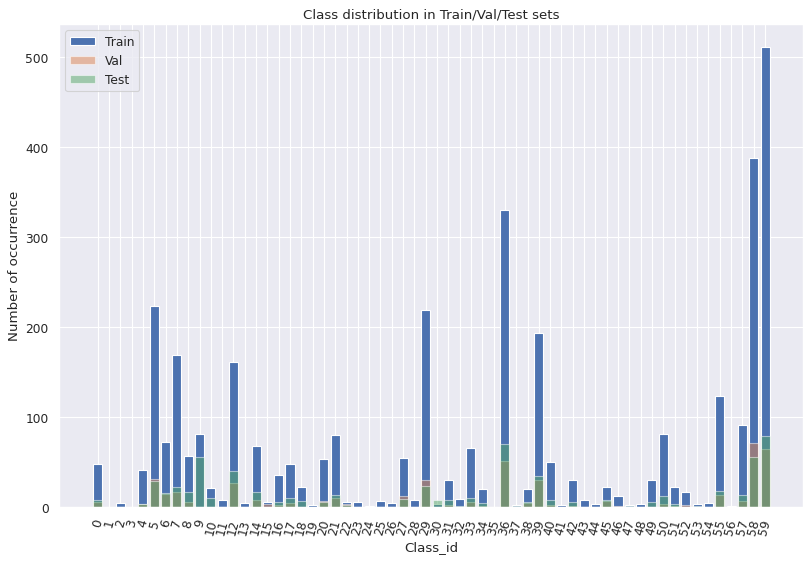

In [92]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)

plt.bar([*range(nr_class)],vis(train_ids),label = 'Train')
plt.bar([*range(nr_class)],vis(val_ids),label = 'Val',alpha = 0.5)
plt.bar([*range(nr_class)],vis(test_ids),label = 'Test',alpha = 0.5)

plt.xticks([*range(nr_class)],rotation = 75)
plt.xlabel("Class_id")
plt.ylabel("Number of occurrence")
plt.title("Class distribution in Train/Val/Test sets")
plt.legend()
plt.show()